In [2]:
# Standard import 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_blobs, make_moons
import itertools

# torch imports
import torch
from torch import nn

# pyro imports
import pyro
from pyro.nn import DenseNN
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# repository imports
from nflib.flows import AffineCoupling, affine_coupling

In [3]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,6)

The Notebook implements the affine coupling transformation as for the RealNVP (Dnih 2017) on a simple (un-conditional) two-moons dataset


### Data

In [4]:
# fix seed
np.random.seed(42)

X, y = make_moons(n_samples=500, noise=0.1)
# transform to tensor
X_tensor, y_tensor = torch.from_numpy(X).float(), torch.from_numpy(y).float()
X.shape, y.shape

((500, 2), (500,))

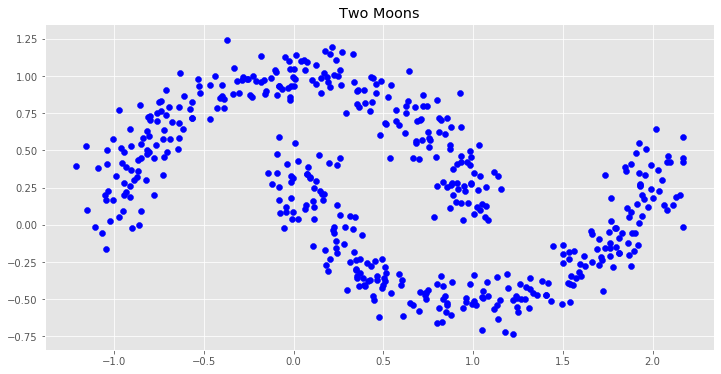

In [5]:
plt.scatter(X[:, 0], X[:, 1], c="b")
plt.title("Two Moons")
plt.show()

Create a Dataset class:

In [6]:
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, X):
        super(TwoMoons, self).__init__()
        self.X = X
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx]

In [7]:
dataset = TwoMoons(X_tensor)

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                        shuffle=True, num_workers=0)

Define the a flow with depth of 6 (i.e. 12 transformations of alternated AffineCoupling and Permute). Every AffineCoupling is defined as a naive FFNN with 1 hidden layer of 128 neurons. 

In [149]:
input_dim = 2
split_dim = 1
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hypernet = DenseNN(input_dim=1, hidden_dims=[20], param_dims=[input_dim-split_dim, input_dim-split_dim])

# Define transformation as an alternation of Affine Coupling and permute
flow_depth = 6
perms = [permute(2, torch.tensor([1, 0])) for i in range(flow_depth)]
transforms = [AffineCoupling(split_dim=1, hypernet=DenseNN(input_dim=1, hidden_dims=[128], param_dims=[input_dim-split_dim, input_dim-split_dim])) for i in range(flow_depth)]
flow = list(itertools.chain(*zip(transforms, perms)))[:-1]
flow_dist = dist.TransformedDistribution(base_distribution=base_dist, transforms=flow)

In [150]:
optimizer = torch.optim.Adam(nn.ModuleList(transforms).parameters(), lr=0.001)

Epoch: 1, NLL: 1357.385
Epoch: 100, NLL: 687.203
Epoch: 200, NLL: 621.711
Epoch: 300, NLL: 594.700
Epoch: 400, NLL: 558.611
Epoch: 500, NLL: 539.701
Epoch: 600, NLL: 555.293
Epoch: 700, NLL: 517.110
Epoch: 800, NLL: 518.795
Epoch: 900, NLL: 506.479
Epoch: 1000, NLL: 503.949
Epoch: 1100, NLL: 508.592
Epoch: 1200, NLL: 523.223
Epoch: 1300, NLL: 513.938
Epoch: 1400, NLL: 510.870
Epoch: 1500, NLL: 508.323


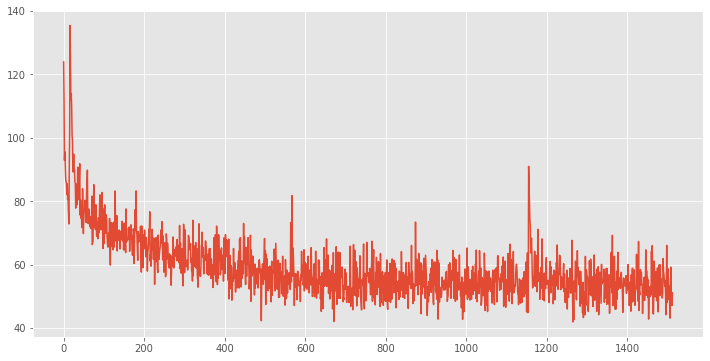

In [151]:
num_epochs = 2000
losses = []

for epoch in range(num_epochs):
    try:
        running_loss = 0
        for x_batch in dataloader:
            optimizer.zero_grad()
            loss = -flow_dist.log_prob(x_batch).sum()
            running_loss += loss

            loss.backward()
            optimizer.step()

        losses.append(loss)
        if epoch%100 == 99 or epoch==0:
            print("Epoch: {0}, NLL: {1:.3f}".format(epoch+1, running_loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break

Once trained, let's sample from the learned distribution (i.e. sampling from the base and sending the sample through the learned transformations)

In [155]:
data = flow_dist.sample(torch.Size([500]))

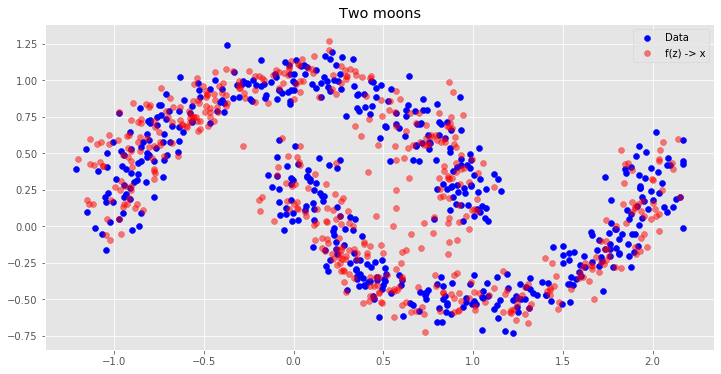

In [156]:
plt.scatter(X[:, 0], X[:, 1], c="b", label="Data")
plt.scatter(data[:, 0], data[:, 1], c="r", alpha=0.5, label="f(z) -> x")
plt.title("Two moons")
plt.legend()
plt.show()

Inverse Transformation

In [157]:
transf_prev = [X_tensor]
for i, flow_i in enumerate(nn.ModuleList(transforms)[::-1]):
    if i < flow_depth-1:
        transf_prev.append(torch.flip(flow_i._inverse(transf_prev[i]), dims=[1]))
    else: 
        transf_prev.append(flow_i._inverse(transf_prev[i]))
transf_prev = [_.detach().numpy() for _ in transf_prev]

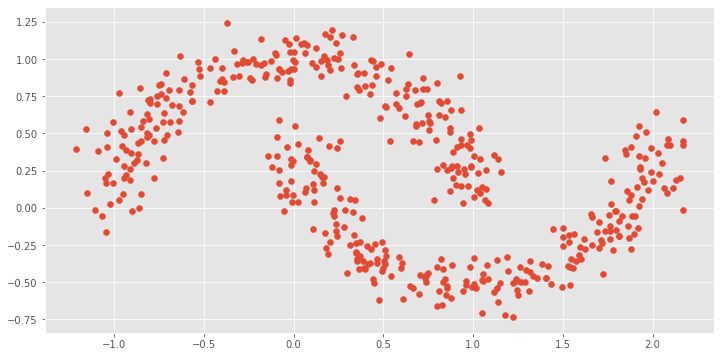

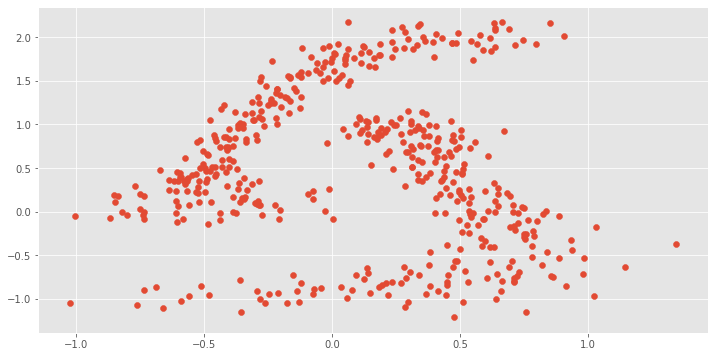

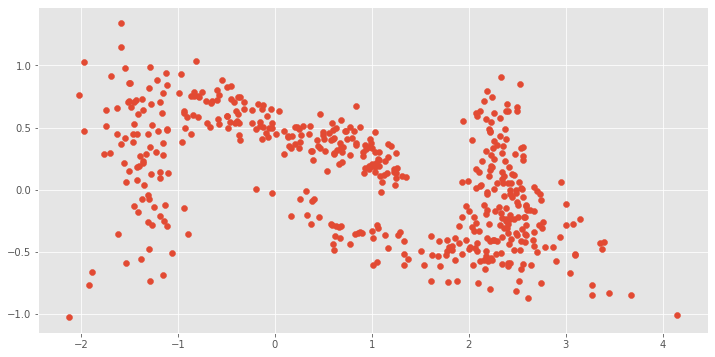

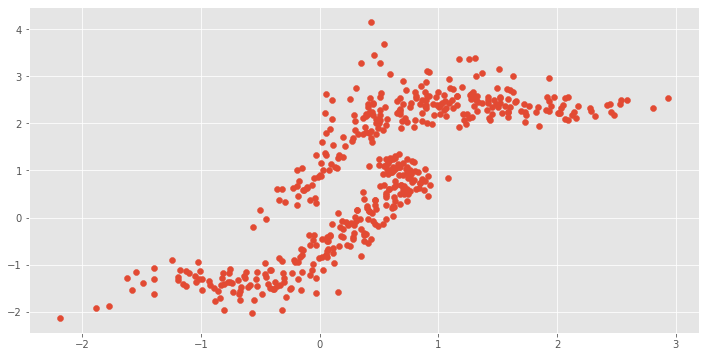

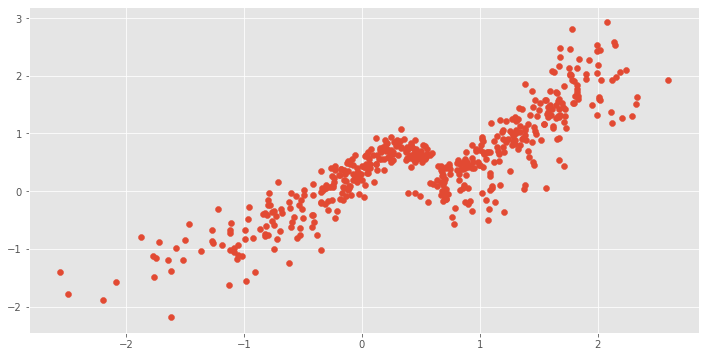

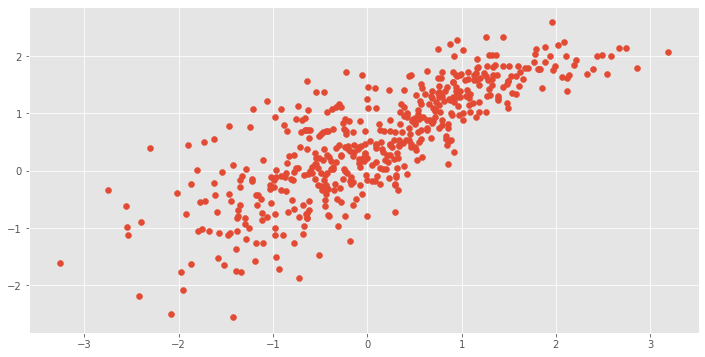

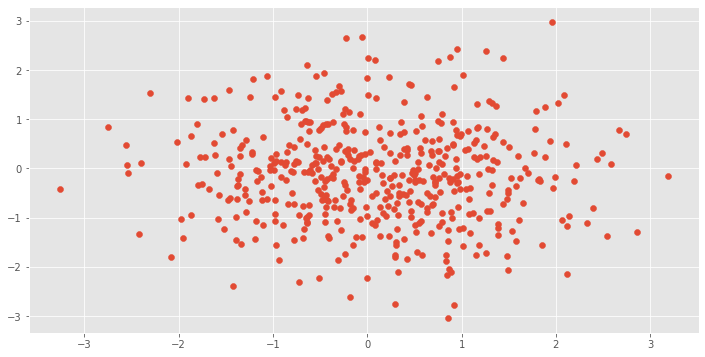

In [158]:
for i in range(len(transf_prev)):
    plt.scatter(transf_prev[i][:,0], transf_prev[i][:,1])
    plt.show()

Forward Transformation

In [159]:
transf_prev = [torch.distributions.Normal(torch.zeros(1000,2), torch.ones(1000,1)).sample()]
for i, flow_i in enumerate(nn.ModuleList(transforms)):
    if i < flow_depth-1:
        transf_prev.append(torch.flip(flow_i._call(transf_prev[i]), dims=[1]))
    else: 
        transf_prev.append(flow_i._call(transf_prev[i]))
transf_prev = [_.detach().numpy() for _ in transf_prev]

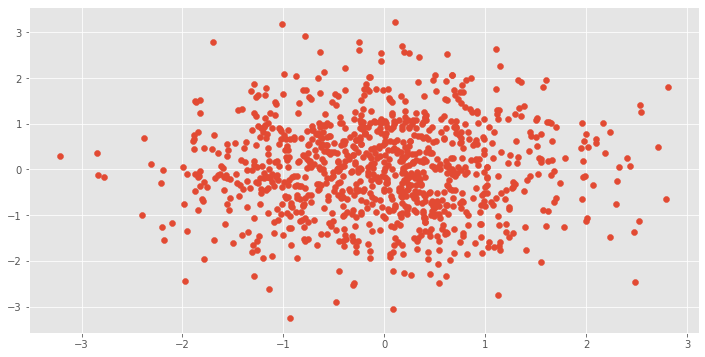

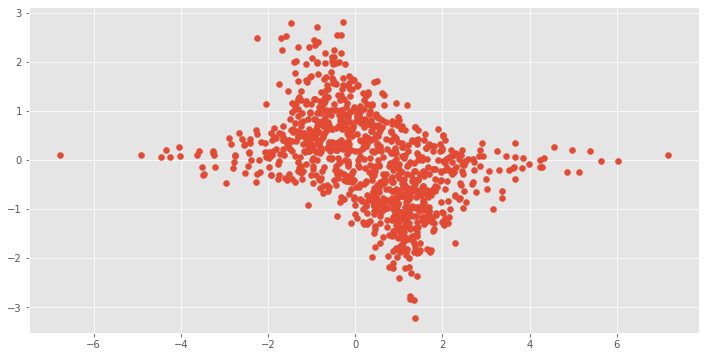

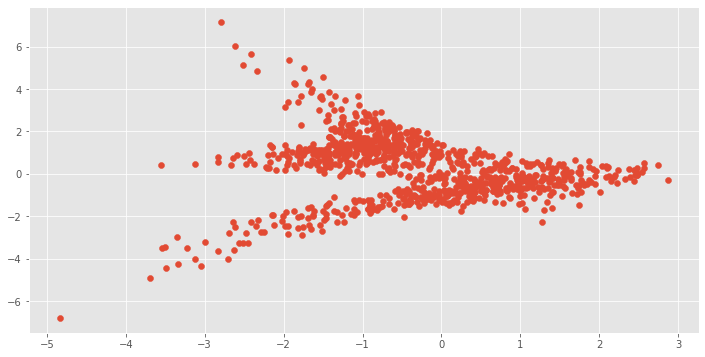

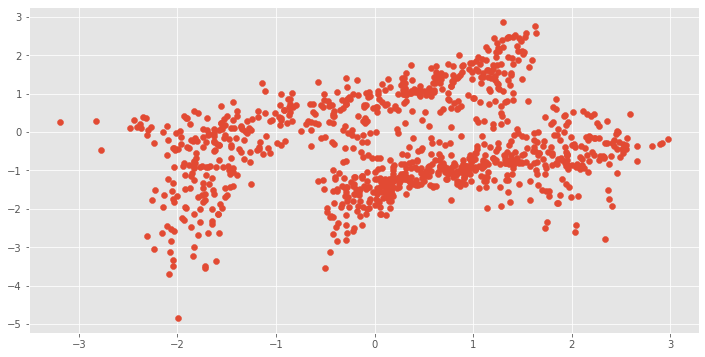

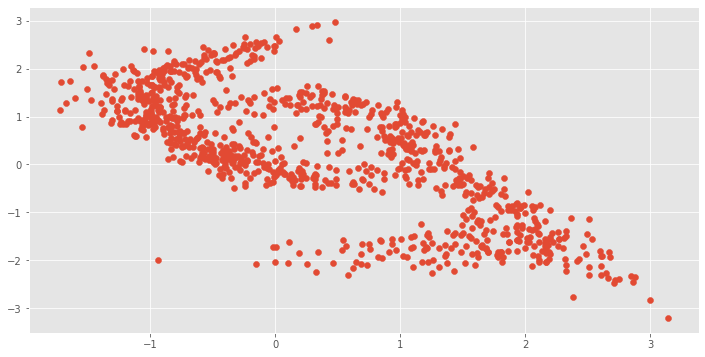

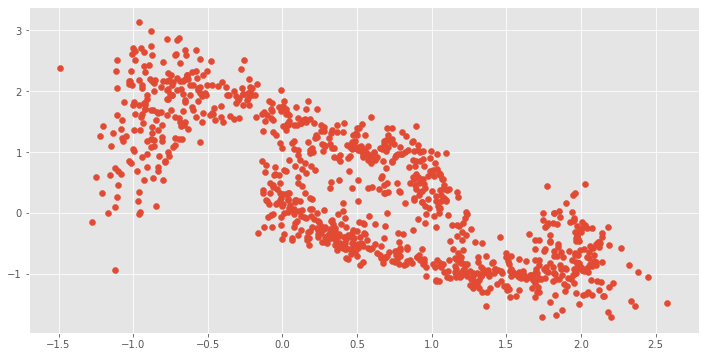

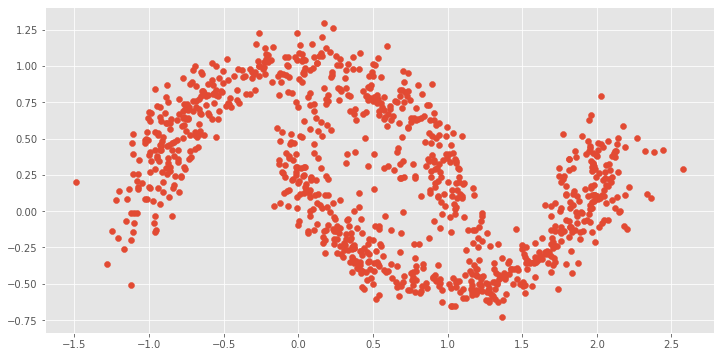

In [110]:
for i in range(len(transf_prev)):
    plt.scatter(transf_prev[i][:,0], transf_prev[i][:,1])
    plt.show()

In [152]:
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = torch.from_numpy(np.stack([xv, yv], axis=-1)).reshape(-1,2).float()

In [153]:
transf_prev = [xy]
for i, flow_i in enumerate(nn.ModuleList(transforms)):
    if i < flow_depth-1:
        transf_prev.append(torch.flip(flow_i._call(transf_prev[i]), dims=[1]))
    else: 
        transf_prev.append(flow_i._call(transf_prev[i]))
transf_prev = [_.detach().numpy() for _ in transf_prev]

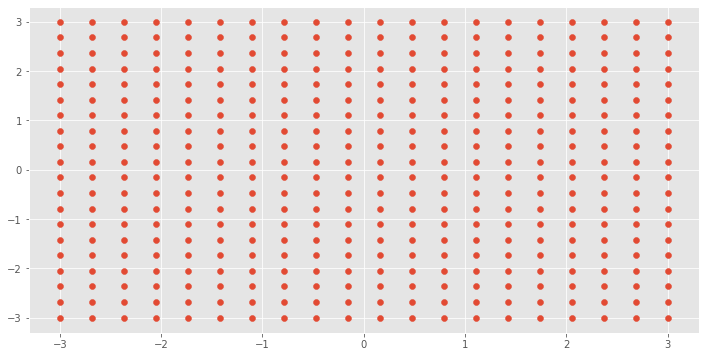

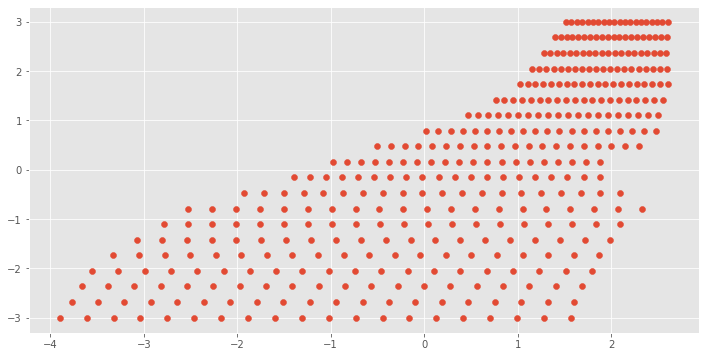

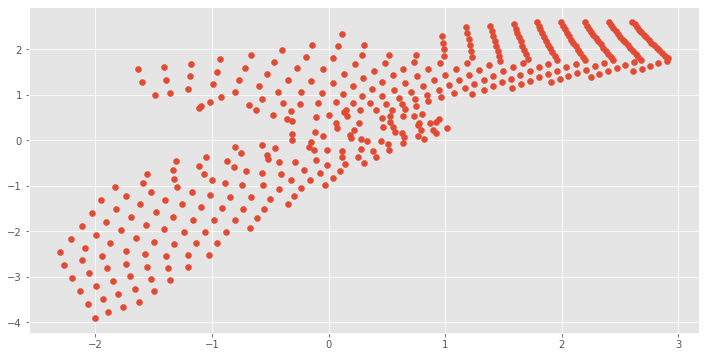

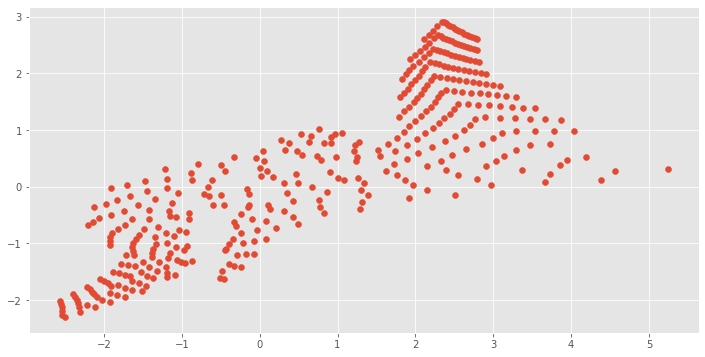

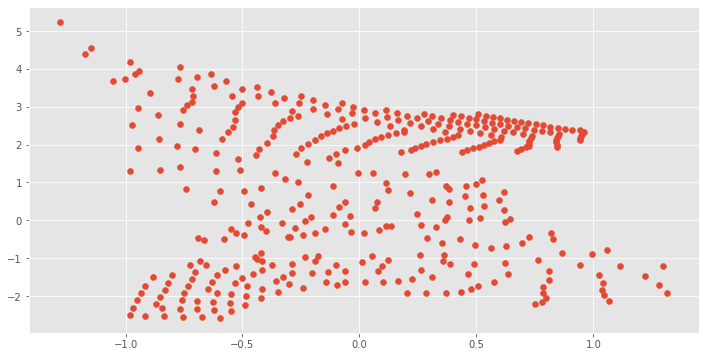

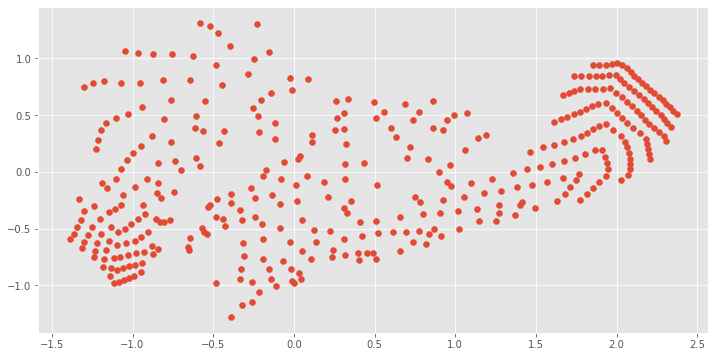

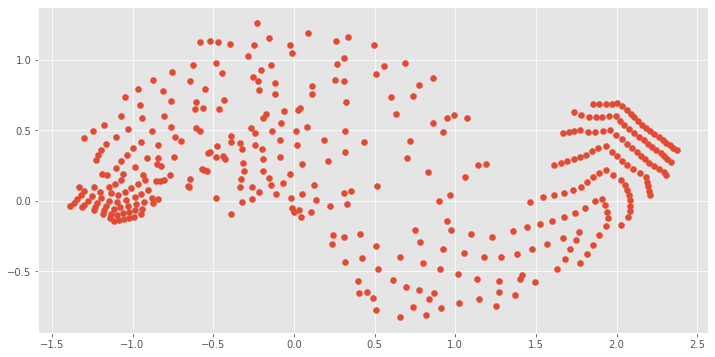

In [154]:
for i in range(len(transf_prev)):
    plt.scatter(transf_prev[i][:,0], transf_prev[i][:,1])
    plt.show()